In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import torch
from torch import nn

In [3]:
import math
import matplotlib.pyplot as plt

In [4]:
import torchvision
import torchvision.transforms as transforms

In [5]:
torch.manual_seed(111)

In [6]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

In [8]:
train_set = torchvision.datasets.MNIST(root='.',train=True,download=True,transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 518kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.55MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.12MB/s]


In [9]:
batch_size=32

train_loader=torch.utils.data.DataLoader(train_set,batch_size=batch_size,shuffle=True)

In [10]:
train_loader

tensor(1)
tensor(1)
tensor(1)
tensor(4)
tensor(8)
tensor(4)
tensor(7)
tensor(2)
tensor(8)
tensor(0)
tensor(4)
tensor(8)
tensor(3)
tensor(7)
tensor(0)
tensor(1)


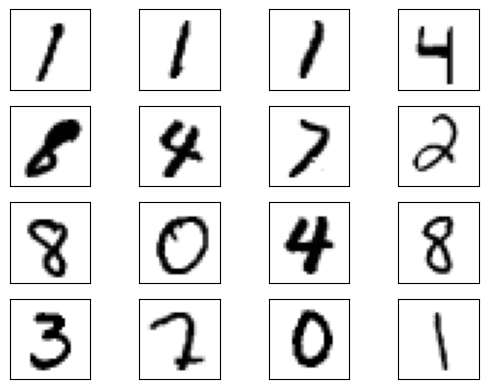

In [11]:
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    print(mnist_labels[i])
    plt.imshow(real_samples[i].reshape(28, 28), cmap="gray_r")

    plt.xticks([])
    plt.yticks([])

In [12]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

In [13]:
discriminator=Discriminator().to(device=device)

In [14]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [15]:
generator=Generator().to(device=device)

In [16]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

In [17]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [18]:
for epoch in range(num_epochs):
    for n,(real_samples,mnist_labels) in enumerate(train_loader):

        #Data for training the discriminator(real & latentspace samples)
        real_samples=real_samples.to(device=device)
        real_sample_labels=torch.ones((batch_size,1)).to(device=device)

        #Taking random 100 coefficients as samples
        latent_space_samples=torch.randn((batch_size,100)).to(device=device)

        #Passing random points to the generator
        generated_samples=generator(latent_space_samples)
        #As they are generated samples, giving the labels as 0
        generated_sample_labels=torch.zeros((batch_size,1)).to(device=device)

        #Creating all samples
        all_samples=torch.cat((real_samples,generated_samples))
        all_sample_labels=torch.cat((real_sample_labels,generated_sample_labels))



        #Training the discriminator
        discriminator.zero_grad()   #in order to accumulate the gradients to zero at every step
        output_discriminator=discriminator(all_samples)
        loss_discriminator=loss_function(output_discriminator,all_sample_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()


        #Data for training the generator
        latent_space_samples=torch.randn((batch_size,100)).to(device=device)


        #Training the generator
        generator.zero_grad()
        generated_samples=generator(latent_space_samples)
        output_discriminator_generated=discriminator(generated_samples)
        loss_generator=loss_function(output_discriminator_generated,real_sample_labels)
        loss_generator.backward()
        optimizer_generator.step()

        #To print the loss
        if n==batch_size-1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")
            plt.show(epoch,loss_discriminator)
            plt.show(epoch,loss_generator)


Epoch: 0 Loss D.: 0.5692472457885742
Epoch: 0 Loss G.: 0.47791537642478943
Epoch: 1 Loss D.: 0.0363135002553463
Epoch: 1 Loss G.: 4.231121063232422
Epoch: 2 Loss D.: 0.0556437224149704
Epoch: 2 Loss G.: 5.603883266448975
Epoch: 3 Loss D.: 0.10942931473255157
Epoch: 3 Loss G.: 5.6956024169921875
Epoch: 4 Loss D.: 0.019327964633703232
Epoch: 4 Loss G.: 4.989902973175049
Epoch: 5 Loss D.: 0.1432429403066635
Epoch: 5 Loss G.: 3.2554521560668945
Epoch: 6 Loss D.: 0.1698130965232849
Epoch: 6 Loss G.: 3.2471437454223633
Epoch: 7 Loss D.: 0.18663746118545532
Epoch: 7 Loss G.: 3.149428367614746
Epoch: 8 Loss D.: 0.1721646785736084
Epoch: 8 Loss G.: 2.389568567276001
Epoch: 9 Loss D.: 0.201675683259964
Epoch: 9 Loss G.: 2.170891523361206
Epoch: 10 Loss D.: 0.31325066089630127
Epoch: 10 Loss G.: 2.2930333614349365
Epoch: 11 Loss D.: 0.2522372305393219
Epoch: 11 Loss G.: 1.9056018590927124
Epoch: 12 Loss D.: 0.29566818475723267
Epoch: 12 Loss G.: 1.861114501953125
Epoch: 13 Loss D.: 0.250222206115

In [19]:
latent_space_sample=torch.randn((batch_size,100)).to(device=device)
generator_samples=generator(latent_space_sample)

In [20]:
type(generator_samples)

torch.Tensor

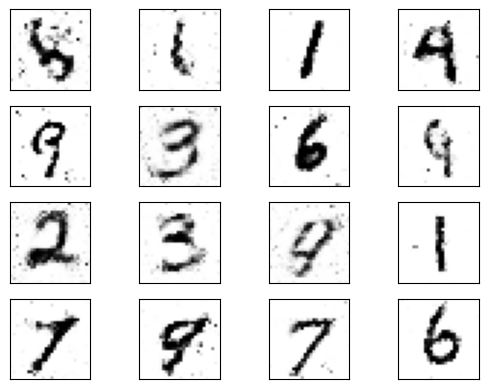

In [21]:
generated_samples = generator_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])